<a href="https://colab.research.google.com/github/JochiSt/AI_PulseReconstruction/blob/main/TestSTM32_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pulse recognition AI

first all the imports

In [570]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Generate template

In [571]:
TOTAL_SAMPLES = 128
RISING_POINTS = 4

def generateTemplate(position = 0, pulse_length = 32, height=1, noise=0, offset=0):

  assert TOTAL_SAMPLES - pulse_length - position - RISING_POINTS * 2 > 0

  # zeroes at front of the pulse
  template = np.zeros(position)

  # create rising edge
  template = np.append(template, np.linspace(0,1,RISING_POINTS, endpoint=False))

  # high part of the pulse
  template = np.append(template, np.ones(pulse_length))

  # create falling edge
  template = np.append(template, np.linspace(1,0,RISING_POINTS, endpoint=False))

  # zeroes after the pulse
  template = np.append(template, np.zeros( TOTAL_SAMPLES - pulse_length - position - 2*RISING_POINTS))

  # multiply by the height to get the right amplitude
  template *= height

  # add some noise
  template  += noise * np.random.randn(*template.shape)

  # add a constant offset
  template += offset

  # clip template to range [0, 255]
  template = np.clip(template, 0, 255)

  # convert to integer
  template = template.astype(int)

  return template

print("template length: ", len(generateTemplate()))

template length:  128


Have a look at the template visually

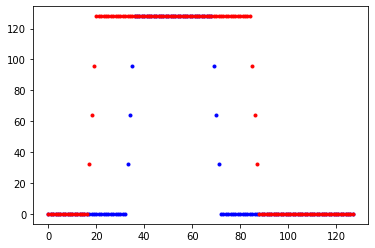

In [572]:
plt.plot(generateTemplate(position = 32, pulse_length=32, height=128), 'b.')
plt.plot(generateTemplate(position = 16, pulse_length=64, height=128), 'r.')
plt.show()

add some noise, and maybe shift the position





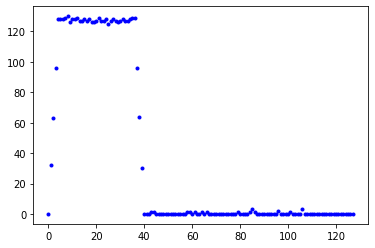

In [573]:
# Plot our data
plt.plot(generateTemplate(height=128, noise=1), 'b.')
plt.show()

## Create Templates for recognision

Generate a couple of templates, which have a pulse in them, and some without any data

26 42 2.4 88
24 47 0.6 183
8 28 2.3 94
49 39 1.7 216
19 50 2.2 58
71 18 1.5 138
10 29 1.0 118
23 60 2.6 89
11 25 0.8 175
46 49 2.0 133


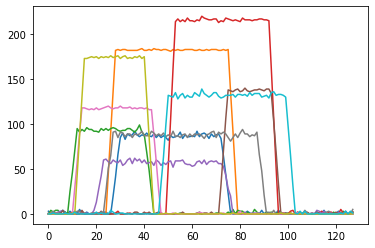

In [574]:
for i in range(10):
  width = np.random.randint(16, 64)               # width of 16 to 64
  position = np.random.randint(0, high=96-width) # arbitrary position
  noise = np.random.randint(1,30)/10.             # 0.1 to 3 LSB noise
  height = np.random.randint(32,250)              # pulse height of 32 to 128

  print(position, width, noise, height)
  plt.plot(generateTemplate(position = position, pulse_length = width, height=height, noise=noise))

plt.show()

# Building the ANN


### Purpose of the ANN
We want to do Pattern Recognition, based on the waveforms shown above.

The output parameters, which we want to reconstruct are:
*   Width
*   Position
*   height


Starting with importing all things, which we need for creating a model

In [575]:
# TensorFlow is an open source machine learning library
import tensorflow as tf
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras

In [576]:
# number of samples for training, testing etc.
SAMPLES = 100000

## Generate the samples
We want to do Pattern recognition, so we have to link the waveforms to the input parameters.

In [577]:
# scale parameters to get values between 0 and 1
SCALE_WIDTH = 64
SCALE_POS = 32
SCALE_HEIGHT = 255

In [578]:
# parameters for template generation
P_width = (8,64)
P_position = (16,24)
P_height = (32, 255)
P_offset = (0,10)

In [579]:
# use fixed value for noise (1st try)
noise = 1 
offset = 5

y_values = []
x_values = []

# generate the waveforms
for i in range(SAMPLES):
  # use random settings
  width = np.random.randint( *P_width )       # width
  position = np.random.randint( *P_position ) # limit position into a certain window
  height = np.random.randint( *P_height )     # pulse height
  offset = np.random.randint( *P_offset )     # constant offset

  x_values.append( (width/SCALE_WIDTH, position/SCALE_POS, height/SCALE_HEIGHT) )
  y_values.append( generateTemplate(position = position, pulse_length = width, height=height, noise=noise, offset=offset) / SCALE_HEIGHT )

# debug printouts
#print(x_values[:2])
#print(y_values[:2])

### Look at the training data
Just make a 2D histogram of all templates.

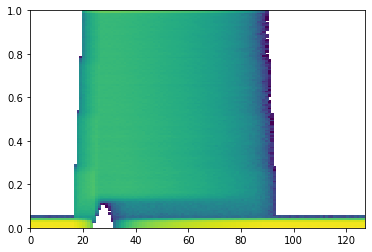

In [580]:
if True:
  plot_x = [ np.arange(128) for i in range(len(y_values)) ]
  plot_x = np.array(plot_x)
  plot_x = plot_x.flatten()
  plot_y = np.array(y_values)
  plot_y = plot_y.flatten()
  plt.hist2d(plot_x, plot_y, bins=128, norm=LogNorm())
  plt.show()

## Split the waveforms into Training, Testing and Validation

In [581]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
print("using %d points for training and %d points for testing"%(TRAIN_SPLIT, TEST_SPLIT))

# convert data into numpy arrays
y_values = np.array(y_values) # parameters
x_values = np.array(x_values) # waveforms

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (len(x_train) + len(x_validate) + len(x_test) ) ==  SAMPLES

using 60000 points for training and 80000 points for testing


## Create the ANN

In [582]:
inputs = keras.Input(shape=(128,), name="waveform_input")

layer_cnt=0
x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001),                       
                       name="layer_%d"%(layer_cnt))(inputs)
layer_cnt+=1

x = keras.layers.Dropout(0.005)(x)

x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001),
                       name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

x = keras.layers.Dropout(0.005)(x)

x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt) )(x)
layer_cnt+=1

x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt) )(x)
layer_cnt+=1

x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt) )(x)
layer_cnt+=1

x = keras.layers.Dense(32,
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

x = keras.layers.Dense(16, 
                       activation='elu',                       
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

x = keras.layers.Dense(16, 
                       activation='elu',                       
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

# final layer for classification
outputs = keras.layers.Dense(3, 
                             activation='elu', 
                             name="classification")(x)

model_1 = keras.Model(inputs=inputs, outputs=outputs, name="network_v0.3")
model_1.summary()

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Model: "network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 waveform_input (InputLayer)  [(None, 128)]            0         
                                                                 
 layer_0 (Dense)             (None, 32)                4128      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 layer_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 layer_2 (Dense)             (None, 32)                1056      
                                                                 
 layer_3 (Dense)             (None, 32)                1056

## Train the model

In [583]:
# Train the model on our training data while validating on our validation set
# remember:
#     y = waveforms
#     x = truth parameters
# just do some trainings to see, whether this structure works or not

#history_1 = model_1.fit(y_train, x_train, epochs=4, batch_size=25, validation_data=(y_validate, x_validate))

In [584]:
# fully train the network
history_1 = model_1.fit(y_train, x_train, epochs=400, batch_size=333, validation_data=(y_validate, x_validate))

# Save the model to disk
#!mkdir -p saved_model
#model_1.save('saved_model/STM32_AI_Test')

Epoch 1/400
181/181 [==============================] - 2s 8ms/step - loss: 0.0348 - accuracy: 0.7573 - val_loss: 0.0153 - val_accuracy: 0.9205
Epoch 2/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0150 - accuracy: 0.9237 - val_loss: 0.0139 - val_accuracy: 0.9452
Epoch 3/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0139 - accuracy: 0.9399 - val_loss: 0.0132 - val_accuracy: 0.9571
Epoch 4/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0132 - accuracy: 0.9495 - val_loss: 0.0127 - val_accuracy: 0.9646
Epoch 5/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0126 - accuracy: 0.9532 - val_loss: 0.0122 - val_accuracy: 0.9668
Epoch 6/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0122 - accuracy: 0.9582 - val_loss: 0.0117 - val_accuracy: 0.9706
Epoch 7/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0118 - accuracy: 0.9613 - val_loss: 0.0115 - val_accuracy: 0.9606

# Evaluate the training performance

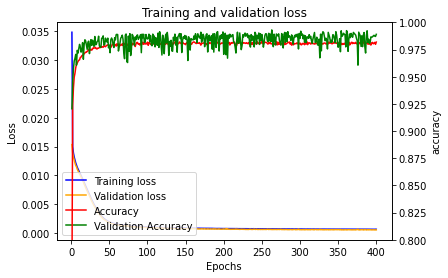

In [585]:
### Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

fig, ax1 = plt.subplots()

p1 = ax1.plot(epochs, train_loss, 'b', label='Training loss')
p2 = ax1.plot(epochs, val_loss, 'orange', label='Validation loss')

ax2 = ax1.twinx()

p3 = ax2.plot(epochs, accuracy, 'r', label='Accuracy')
p4 = ax2.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')

ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('accuracy')
ax2.set_ylim([0.8,1])

lns = p1+p2+p3+p4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower left')

plt.show()

In [586]:
# evaluate the keras model
_, accuracy = model_1.evaluate(y_validate, x_validate)
print('Accuracy: %.2f' % (accuracy*100))

625/625 [==============================] - 2s 2ms/step - loss: 5.8598e-04 - accuracy: 0.9890
Accuracy: 98.90


In [587]:
# Test a couple of waveforms
# remember:
#     y = waveforms
#     x = truth parameters

x_test = x_values[1]
y_test = np.array(generateTemplate(position = int(x_test[0]*SCALE_POS), 
                                   pulse_length = int(x_test[1]*SCALE_WIDTH), 
                                   height=int(x_test[2]*SCALE_HEIGHT), 
                                   noise=0
                                   )/SCALE_HEIGHT)

# waveform needs to be reshaped to be fed into ANN
y_test = y_test.reshape(1,128)

# try, whether we can reconstruct the parameters x_test from the waveform y_test
model_1.make_predict_function()
x_test_pred = np.array(model_1.predict(y_test)[0])

print("sample pulse created: ", x_test)
print("ANN reconstructed:    ", x_test_pred)

sample pulse created:  [0.390625   0.5        0.97254902]
ANN reconstructed:     [0.37948453 0.47619396 0.91966707]


## Have a look at the reconstructed parameters

Get some random pulses, and have a look how they are reconstructed by the network.


In [588]:
# number of test waveforms
TEST_SAMPLES = 1000

In [589]:
waveforms = []        # generated waveforms
orig_parameters = []  # parameters, which are used for the generation
NN_parameters = []    # parameters, reconstructed by the NN

# vary the parameters to have a look a the performance outside the trained 
# parameter boundaries.
parameter_variation = 0.1

# increase the range of parameters in order to see, what is happening
T_width    = ( P_width[0]    * (1 - parameter_variation) , P_width[1]    * (1 + parameter_variation) )
T_position = ( P_position[0] * (1 - parameter_variation) , P_position[1] * (1 + parameter_variation) )
T_height   = ( P_height[0]   * (1 - parameter_variation) , P_height[1]   * (1 + parameter_variation) )

# generate the waveforms
for i in range(TEST_SAMPLES):
  # use random settings
  width = np.random.randint( *T_width )
  position = np.random.randint( *T_position )
  height = np.random.randint( *T_height )

  waveforms.append( np.array(generateTemplate(position = position, pulse_length = width, height=height, noise=noise, offset=offset) / SCALE_HEIGHT ) )
  orig_parameters.append( (width/SCALE_WIDTH, position/SCALE_POS, height/SCALE_HEIGHT) )

In [590]:
for i in range(TEST_SAMPLES):
  # waveform needs to be reshaped to be fed into ANN
  waveform = waveforms[i].reshape(1,128)
  NN_parameters.append( np.array( model_1.predict(waveform)[0]) )


Plot the distributions

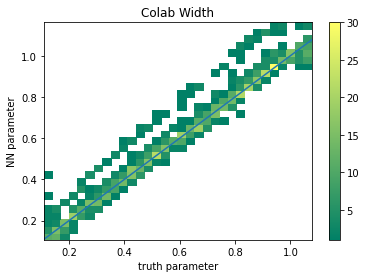

In [591]:
plot_x = [k[0] for k in orig_parameters]
plot_y = [k[0] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, cmin=1, cmap='summer')
plt.vlines(np.array(P_width),ymin=0, ymax=100)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.colorbar()
plt.title("Colab Width")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

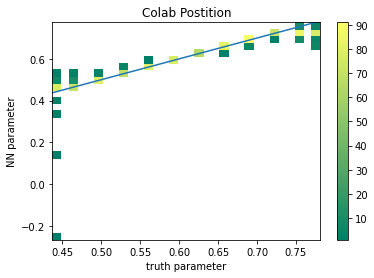

In [592]:
plot_x = [k[1] for k in orig_parameters]
plot_y = [k[1] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, cmin=1, cmap='summer')
plt.vlines(np.array(P_position),ymin=0, ymax=100)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.colorbar()
plt.title("Colab Postition")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

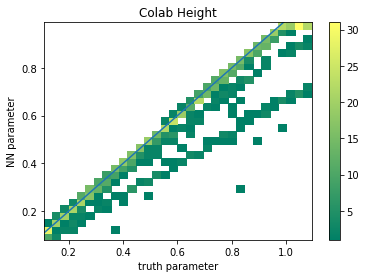

In [593]:
plot_x = [k[2] for k in orig_parameters]
plot_y = [k[2] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, cmin=1, cmap='summer')
plt.vlines(np.array(P_height),ymin=0, ymax=1000)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.colorbar()
plt.title("Colab Height")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

# What happens at zero input?
What if the input array is all zero?

In [594]:
# waveform needs to be reshaped to be fed into ANN
waveform = np.zeros(128)
waveform = waveform.reshape(1,128)
print( model_1.predict(waveform)[0] )

[0.3023837  0.56414634 0.01720621]


# Export to STM32

following:
This [tutorial](https://www.digikey.de/en/maker/projects/tinyml-getting-started-with-stm32-x-cube-ai/f94e1c8bfc1e4b6291d0f672d780d2c0) from DigiKey 

In [595]:
# settings
tflite_model_name = 'pulse_reco'  # Will be given .tflite suffix
c_model_name = 'pulse_reco'       # Will be given .h suffix

In [596]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # option OPTIMIZE_FOR_SIZE is deprecated
tflite_model = converter.convert()

open(tflite_model_name+'.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbqpiypbe/assets


INFO:tensorflow:Assets written to: /tmp/tmpbqpiypbe/assets


17344

For usage inside the [STM32Cube.AI](https://www.st.com/content/st_com/en/support/learning/stm32-education/stm32-moocs/Introduction_to_STM32CubeAI_MOOC.html) it is sufficient to just have the tensorflow light model. The special export seems not be needed.

We have to define a special function, which exports our data into a H-file, which can be later used and included into our microcontroller code.

The function is from https://gist.github.com/ShawnHymel/79237fe6aee5a3653c497d879f746c0c

## Test the TFlite model

In [597]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_name+".tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

input_data = np.array( y_test, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])[0]

print("sample pulse created:    ", x_test)
print("TFlite reconstructed:    ", output_data)

sample pulse created:     [0.390625   0.5        0.97254902]
TFlite reconstructed:     [0.37550986 0.47450837 0.9166776 ]
